eff_an 0.019801320326652605 eff_an_newton 0.019801326693244747 diff -6.366592142370564e-09 error 3.215235141058774e-05
epsilon 752079.8752757446 tau 0.02 beta -13.223744662648818 cl 99.99653413551626 w (6.516584158941292e-07+0j)
eff_an 0.019801187687596644 eff_an_newton 0.019801326693244747 diff -1.390056481032076e-07 error 0.0007020016903747646
epsilon 34908.45551064783 tau 0.02 beta -10.153624376078065 cl 99.99653413551626 w (1.4039462893586018e-05+0j)
eff_an 0.0197983329137269 eff_an_newton 0.019801326693244747 diff -2.9937795178458515e-06 error 0.015119085525048098
epsilon 1620.3069729689184 tau 0.02 beta -7.083363800471762 cl 99.99653413551626 w (0.00030242833162740684+0j)
eff_an 0.019737225213322884 eff_an_newton 0.019737240164608316 diff -1.495128543194113e-08 error 7.575165173675556e-05
epsilon 75.20798752757446 tau 0.02 beta -4.010086008524647 cl 9.802627598353916e-07 w (0.006495913952253419+0j)
eff_an 0.01857778876558136 eff_an_newton 0.018577789467534966 diff -7.019536063523

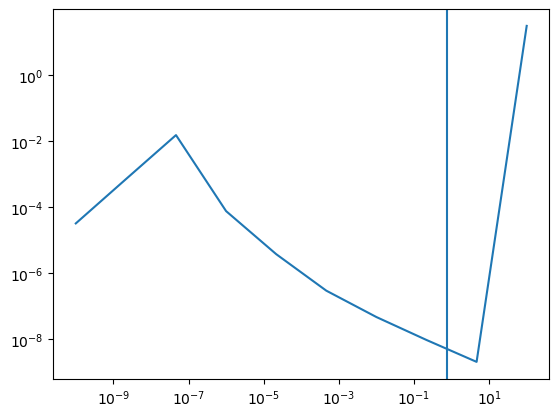

In [173]:
import sys
import os
sys.path.append(os.path.abspath('..'))
import numpy as np 
from regex import D
from scipy.optimize import minimize
from scipy.special import lambertw
from matplotlib import pyplot as plt
c_vec=np.logspace(-10,2,10)
w_vec=np.array([])
eff_an_v=np.array([])
epsilon_v=np.array([])
for c in c_vec:
    c_in=c
    Solubility=1E-3
    K_S=1E-2
    D   =1E-9
    k_t =1E-5
    d_Hyd=1E-2
    thick=1E-3
    L=10
    U0=2
    tau = 4 * k_t * L / (U0 * d_Hyd)
    epsilon = (
                    1
                    / c_in
                    / Solubility
                    * (
                        0.5
                        * K_S
                        * D
                        / (
                            k_t
                            * d_Hyd
                            * np.log(
                                (d_Hyd + 2 * thick)
                                / d_Hyd
                            )
                        )
                    )
                    ** 2
                )

    if epsilon > 1e2:
                    eff_an_newton = 1 - np.exp(-tau)
    elif epsilon**0.5 < 1e-4 and tau < 1 / epsilon**0.5:
                    eff_an_newton = 1 - (1 - 0.5*tau * epsilon**0.5) ** 2
    else:  
                    beta = (1 / epsilon + 1) ** 0.5 + np.log(
                        (1 / epsilon + 1) ** 0.5 - 1
                    )

                    def eq(var):
                        cl = var
                        alpha = epsilon * c_in
                        left = (cl / alpha + 1) ** 0.5 + np.log((cl / alpha + 1) ** 0.5 - 1+1e-10)
                        right = beta - tau

                        return abs(left - right)

                    cl = minimize(
                        eq,
                        c_in / 2,
                        method="Powell",
                        bounds=[(0, c_in)],
                        tol=1e-7,
                    ).x[0]
                    eff_an_newton = 1 - (cl / c_in)
    beta = (1 / epsilon + 1) ** 0.5 + np.log(
                        (1 / epsilon + 1) ** 0.5 - 1
                    )
    max_exp = np.log(np.finfo(np.float64).max)
    beta_tau = beta - tau - 1
    if beta_tau > max_exp:
        print("Warning: Overflow encountered in exp, input too large.Error may be up to 40%. Suggested to use the newton_flag=True option.")
        # Handle the overflow case here, e.g., by setting a maximum value
        z = np.finfo(np.float64).max
        # z=np.float128(np.exp(beta_tau))
        #w = lambertw(z, tol=1e-10)
        w=beta_tau-np.log(beta_tau)
    else:
        z = np.exp(beta_tau)
        w = lambertw(z, tol=1e-10)
    
    eff_an = 1 - epsilon * (w**2 + 2 * w)
    epsilon_v=np.append(epsilon_v,epsilon)
    eff_an_v=np.append(eff_an_v,eff_an-eff_an_newton)
    if eff_an.imag != 0:
        raise ValueError("eff_an has a non-zero imaginary part")
    else:
        eff_an = eff_an.real  # get rid of 0*j
    w_vec=np.append(w_vec,(abs(eff_an-eff_an_newton)/eff_an_newton*100))
    print("eff_an",eff_an,"eff_an_newton",eff_an_newton,"diff",eff_an- eff_an_newton,"error",abs(eff_an-eff_an_newton)/eff_an_newton*100)
    print("epsilon",epsilon,"tau",tau,"beta",beta,"cl",cl,"w",w)
plt.loglog(c_vec,abs(w_vec))
plt.axvline(0.75)

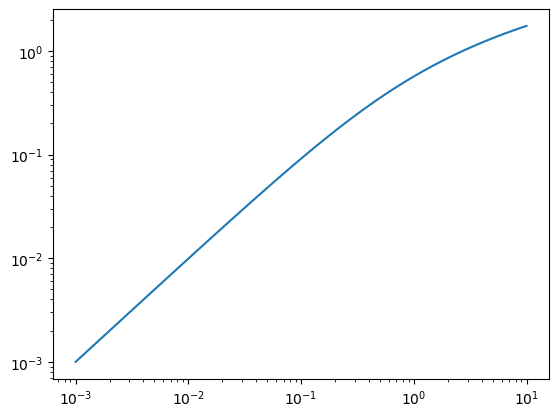

In [174]:
A_vec=np.logspace(-3,1,100)
plt.loglog(A_vec,lambertw(A_vec, tol=1e-5))